# Recovering a 2d function from its gradient with a Gaussian Process Regression model

This notebook shows examples on how to use the present gaussian process regression framework to formally integrate functions from derivative observations.

This example will show how to predict a 2D function using gradient observations with both a full GPR and a sparse GPR. The sparse GPR framework works by projecting the training data into a lower dimensional feature space in order to reduce the computational cost (mainly matrix inversions).

## Creating the training data set

`jax.numpy` has almost the same usage as the standard `numpy` package, with the caveat that `jax.ndarray` is an immutable type, meaning that no inplace changes can be made. For creating training data this should however not be an issue.

In [207]:
import jax.numpy as jnp
from jax import random
import jax

We will model a forth order polynomial:

In [208]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0 + random.normal(key,(len(x),), dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    dx1 = 4 * (x[:,0]**2 + x[:,1] - 11) * x[:,0] + 2 * (x[:,0] + x[:,1]**2 -7)
    dx2 = 2 * (x[:,0]**2 + x[:,1] - 11) + 4 * (x[:,0] + x[:,1]**2 -7) * x[:,1]
    return jnp.vstack((dx1, dx2)).T / 800.0 + random.normal(key,x.shape, dtype=jnp.float32)*noise

To define the training data we first need to define boundaries to choose the datapoints from. Then, random points are chosen in this interval. `random.split` creates a new subkey from the previous key to get a new sudo-random sample from the uniform distribution.

In [209]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
num_f_vals = 2
num_d_vals = 100

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, 2), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals,2), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.1
key, subkey = random.split(key)
y_func = fun(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = grad(x_der, noise, subkey)

The GPR framework needs as input for training a tuple of arrays `X_split` of which contains a set of points where the function is sampled and a set of points where the gradient is sampled. Both array in `X_split` is of shape `(n_samples_i, N)`. `X_split` should be ordered as follows: the first array represents the datapoints for the function observations and the second array represents the gradient of the function. `Y_train` should just be an array of shape `(n_samples_function + n_samples_gradient,)`.

In [210]:
X_split = [x_func,x_der]

Y_train = jnp.hstack((y_func, y_der.reshape(-1)))

### Defining the Kernel and its initial parameters

The kernels can be found in `jaxgp.kernels`. Currently implemented are `RBF`, `Linear`, and `Periodic` kernels. When in doubt what kernel to use, go with an `RBF` kernel.

In [211]:
from jaxgp.kernels import RBF

kernel = RBF()
# an RBF kernel has per default 2 parameters
init_kernel_params = jnp.array([2.0, 2.0])

## The full GPR model

### Training the full GPR model

The regression models can be found in `jaxgp.regression`. The `ExactGPR` model takes as inital arguments a kernel to use, initial parameters for the kernel and a noise parameter that underlies the noisy datageneration.

Additionally one can also give the model a logging function that saves the parameters at each step of the optimization. For this a convenience class `Logger` can be found in `jaxgp.utils`.

In [212]:
from jaxgp.regression import ExactGPR
from jaxgp.utils import Logger

logger = Logger()
model = ExactGPR(kernel, init_kernel_params, noise, logger=logger)

In [213]:
model.train(X_split, Y_train)

OptStep(params=DeviceArray([2.8879304, 4.5738873], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-144.76248, dtype=float32, weak_type=True), success=True, status=0, iter_num=13))


Iterations of the parameters during optimization.

In [214]:
print(logger.iters_list)

[DeviceArray([[1.9696913, 2.9995406],
             [1.9110345, 3.3551724],
             [1.7367128, 4.1002364],
             [1.7143581, 4.3180556],
             [1.7436137, 4.2432656],
             [1.8470137, 4.2703   ],
             [2.3368526, 4.4459233],
             [2.591094 , 4.5185723],
             [2.7727664, 4.552289 ],
             [2.8618753, 4.5689235],
             [2.8879247, 4.5738864],
             [2.8879304, 4.5738873],
             [2.8879304, 4.5738873]], dtype=float32)]


### Making predictions with the trained model

We will make predictions on an evenly spaced grid of 10201 points square box defined by the above bounds.

In [215]:
predict_grid = jnp.array(jnp.meshgrid(jnp.linspace(*bounds, 101), jnp.linspace(*bounds, 101))).T.reshape(101**2, 2)
print(predict_grid.shape)

# model.eval returns a mean prediction and a confidence interval around the mean prediction
means, stds = model.eval(predict_grid)

(10201, 2)


### Visualizing the result

Plotting the predicted function together with its confidence interval we can see that even with only a few datapoints the prediction works good. The shaded region describes the $1\sigma$ confidence interval around the prediction.

Text(0.5, 1.0, 'true in $1\\sigma$ conf')

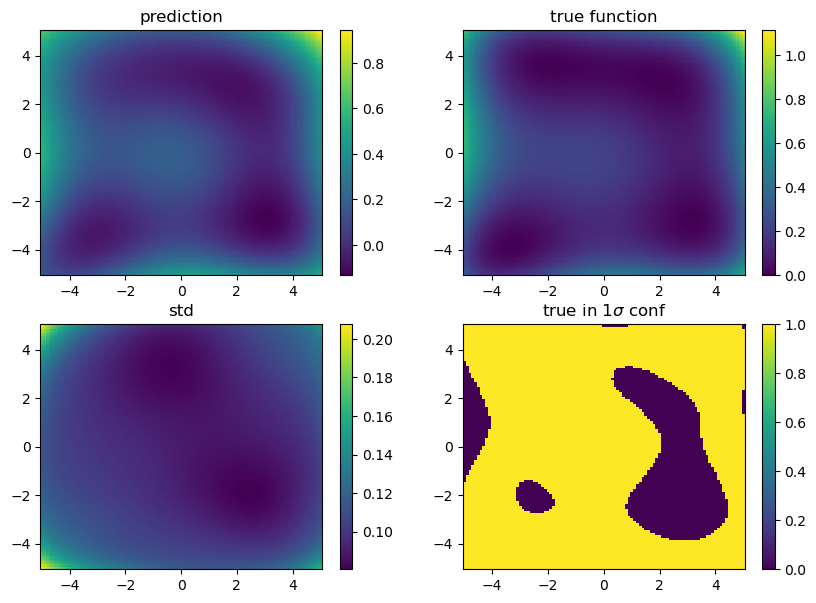

In [216]:
import matplotlib.pyplot as plt

means = means.reshape(101,101)
stds = stds.reshape(101,101)
true = fun(predict_grid).reshape(101,101)

fig, ax = plt.subplots(2, 2, figsize=(10,7))

mesh = jnp.meshgrid(jnp.linspace(*bounds, 101),jnp.linspace(*bounds, 101))

im1 = ax[0,0].pcolormesh(*mesh, means)
im2 = ax[0,1].pcolormesh(*mesh, true)
im3 = ax[1,0].pcolormesh(*mesh, stds)
im4 = ax[1,1].pcolormesh(*mesh, jnp.greater(true, means-stds)*jnp.less(true, means+stds))


plt.colorbar(im1, ax=ax[0,0])
plt.colorbar(im2, ax=ax[0,1])
plt.colorbar(im3, ax=ax[1,0])
plt.colorbar(im4, ax=ax[1,1])

ax[0,0].set_title("prediction")
ax[0,1].set_title("true function")
ax[1,0].set_title("std")
ax[1,1].set_title("true in $1\sigma$ conf")